# Anwendung eines Random Forest
## Implementierung nach Geppert et al. (2022) und Hartmann et al. (2023)

In ihrer Studie untersuchten Geppert et al. die jährliche Niederschlagsverteilung in Südafrika. Stabile Isotope im Wasser unterscheiden sich je nach Herkunft und Kontakt mit bestimmten Materialien. So bleiben Moleküle mit schwereren Isotopen von Sauerstoff ($^{18}$O) und Wasserstoff ($^{2}$H) im Meer zurück, wenn das Wasser dort verdunstet. 
Daher lässt sich der Weg des Wassers durch die Untersuchung des Verhältnisses von stabilen Isotopen in den Wassermolekülen nachvollziehen. 

Im Folgenden wird ein Random-Forest-Modell angewendet um anhand der erhobenen Daten zu analysieren, wie groß der Einfluss der verschiedenen Variablen auf das Verhältnis $\delta ^{18}$O ist.

In [1]:
# Importieren der notwendigen Libraries und Pakete
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import random
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor 

# Einstellung der Ansicht der dataframes (Anzeige aller Spalten und Zeilen)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Daten

## Datensatz einlesen

In [2]:
df = pd.read_csv("C:/Users/svenj/Documents/Uni/Vorlesungen/KI in der Landnutzungsänderung/Geppert2019.csv", header=0, encoding = 'utf-8')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191 entries, 0 to 190
Data columns (total 62 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Unnamed: 0          191 non-null    object 
 1   Prc.sum             191 non-null    float64
 2   expl.frac           191 non-null    float64
 3   wmSrc_time          191 non-null    float64
 4   wmSrc_lon           191 non-null    float64
 5   wmSrc_lat           191 non-null    float64
 6   wmSrc_p             191 non-null    float64
 7   wmSrc_Z             191 non-null    float64
 8   wmSrc_nocfblh       191 non-null    float64
 9   wmSrc_T             191 non-null    float64
 10  wmSrc_Q             191 non-null    float64
 11  wmSrc_PS            191 non-null    float64
 12  wmSrc_evs           191 non-null    float64
 13  wmSrc_RH            191 non-null    float64
 14  wmSrc_dQ            191 non-null    float64
 15  wmSrc_Q.upt         191 non-null    float64
 16  wmSrc_Pr

Der Datensatz hat 62 Spalten (oder Variablen) und 191 Zeilen (features). 
Die Daten liegen in den Formaten "float64" und "int64", also als numerische Werte vor. 
Fünf Spalten haben das Format "object", enthalten also Text oder kategorische Daten.

## Preprocessing
Die Spalte mw18O enthält die Daten des hier betrachteten Isotops $^{18}$O und wird umbenannt zu "O18". Das Isotop $^{2}$H und weitere überflüssige Spalten werden aus dem Datensatz entfernt.

In [3]:
# Spalten neu benennen
df = df.rename(columns={"mw18O": "O18",
                            "mwdD": "H2",
                            "Monat": "month",
                           })

In [4]:
# Unnötige Spalten löschen
IsoW = df.drop(columns=['H2', 'd.Excess', 'Land.Ocean', 'Africa', 'Oceans', 'ISO'])

Analog zur Studie werden die Daten nach der explanatory fraction gefiltert. Nur Features mit einem Wert über 0.6 werden behalten.

In [5]:
# nach explanatory fraction über 0.6 filtern
IsoW_06 = IsoW[IsoW['expl.frac']> 0.6] 

Die Spalte "samplesite" enthält zu jedem feature einen eigenen Namen als Text und wird dür diese Untersuchung in einen Index umgewandelt, um leichter damit arbeiten zu können. Beim späteren one-hot-encoding würde sonst jede sample site eine eigene Spalte bekommen.

In [6]:
IsoW_06["samplesite"] = IsoW_06.index
IsoW_06_float = IsoW_06.drop('Unnamed: 0', axis=1)
iso = IsoW_06_float

C:\Users\svenj\AppData\Local\Temp\ipykernel_36364\586495007.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  IsoW_06["samplesite"] = IsoW_06.index


Die weiteren kategorischen Variablen werden durch one-hot-encoding in "boolean"-Daten umgewandelt. Es liegt nun je eine Spalte für jede Kategorie der Variablen vor. Für jedes feature ist hinterlegt, ob die Kategorie hier zutrifft ("True") oder nicht ("False"). 

In [7]:
# one hot encoding
iso = pd.get_dummies(iso, drop_first=True)
iso.info()

<class 'pandas.core.frame.DataFrame'>
Index: 117 entries, 0 to 188
Data columns (total 71 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Prc.sum                  117 non-null    float64
 1   expl.frac                117 non-null    float64
 2   wmSrc_time               117 non-null    float64
 3   wmSrc_lon                117 non-null    float64
 4   wmSrc_lat                117 non-null    float64
 5   wmSrc_p                  117 non-null    float64
 6   wmSrc_Z                  117 non-null    float64
 7   wmSrc_nocfblh            117 non-null    float64
 8   wmSrc_T                  117 non-null    float64
 9   wmSrc_Q                  117 non-null    float64
 10  wmSrc_PS                 117 non-null    float64
 11  wmSrc_evs                117 non-null    float64
 12  wmSrc_RH                 117 non-null    float64
 13  wmSrc_dQ                 117 non-null    float64
 14  wmSrc_Q.upt              117 no

# Random Forest

Das initiale Random-Forest-Modell wird aufgesetzt. Dafür wird das der RandomForestRegressor aus der sklearn-Bibliothek verwendet. Das Modell hat 2000 "Bäume", also einzelne Decision Trees und trifft eine Vorhersage für $\delta ^{18}$O basierend auf allen anderen Variablen. Das Modell wird mit O18 als Zielvariable (labels) und den anderen Variablen (features) gefittet.

Für die Reproduzierbarkeit wird der "random seed" benannt, der eine bestimmte Zahlensequenz als Ausgangspunkt für den Zufallsgenerator festlegt. 

In [8]:
# festlegen des random seed
my_seed = 196
random.seed(my_seed)

In [10]:
labels = np.array(iso['O18'])
features = iso.drop('O18',axis=1)
features = np.array(features)

model1 = RandomForestRegressor(n_estimators = 2000, random_state = my_seed, oob_score = True)
model1.fit(features, labels)

y_pred = model1.predict(features)

# Fehler berechnen, um später Performance des Models beurteilten zu können
mse_model1 = mean_squared_error(labels, y_pred)
r2_model1 = model1.score(features, labels)

print(f'MSE: {mse_model1}')
print(f'R2: {r2_model1}')

MSE: 0.44708715367452756
R2: 0.9327339976451685


## Hyper-Parameter Tuning

Die beiden Parameter der Anzahl (n_estimators) und optimalen Tiefe (max_depth) der Decision Trees des Modells werden für eine bessere Performance angepasst. Hierfür wird das Modell mit einer Reihe an Parameter-Werten gefittet und jeweils der "Mean Squared Error" (MSE) als Maß für die Modell-Performance ausgegeben und graphisch dargestellt. Der MSE misst die durchschnittliche quadratische Abweichung zwischen den vorhergesagten Werten des Modells und den tatsächlichen Werten im Testdatensatz. Je geringer der MSE, desto besser die Vorhersage durch das Modell.

Bestimmen der optimalen Anzahl an Decision Trees (n_estimators):

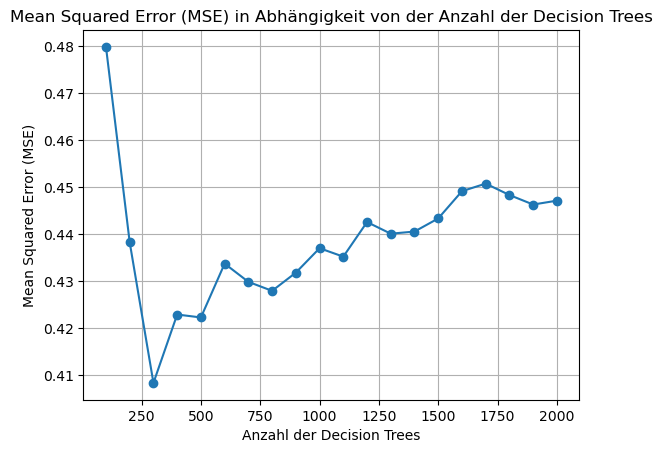

Die optimale Anzahl ist 300 mit einem MSE von 0.4083


In [11]:
n_estimators_list = list(range(100, 2100, 100)) #Werte von n_estimators (von 100 bis 2100, in 100er-Schritten)

mse_scores = [] # Liste für Sammlung der MSE-Werte

# Schleife zum durchlaufen des Modells mit allen n_estimator-Werten der Liste, speichert den erreichneten MSE jedes Durchlaufs in der Liste mse_scores
for n_estimators in n_estimators_list:
    model = RandomForestRegressor(n_estimators=n_estimators, random_state=my_seed)
    model.fit(features, labels)
    y_pred = model.predict(features)
    mse = mean_squared_error(labels, y_pred)
    mse_scores.append(mse)

# Ergebnisse plotten
plt.plot(n_estimators_list, mse_scores, marker='o')
plt.title('Mean Squared Error (MSE) in Abhängigkeit von der Anzahl der Decision Trees')
plt.xlabel('Anzahl der Decision Trees')
plt.ylabel('Mean Squared Error (MSE)')
plt.grid(True)
plt.show()

best_n_estimators = n_estimators_list[mse_scores.index(min(mse_scores))]
best_mse_model2 = min(mse_scores)

print(f'Die optimale Anzahl ist {best_n_estimators} mit einem MSE von {best_mse_model2:.4f}')

Bestimmen der optimalen Decision-Tree-Tiefe:

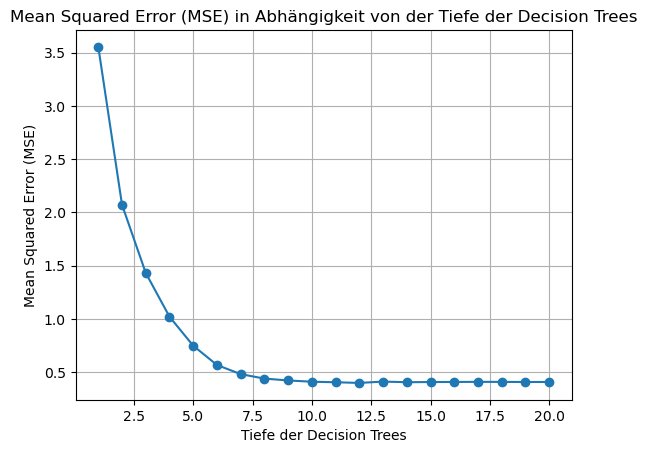

Die optimale max_depth ist 12 mit einem MSE von 0.3994


In [12]:
max_depth_list = list(range(1, 21, 1))

# Liste für MSE-Werte
mse_scores = []

# Schleife zum durchlaufen des Modells mit allen max_depth-Werten der Liste, speichert den erreichneten MSE jedes Durchlaufs in der Liste mse_scores
for max_depth in max_depth_list:
    model = RandomForestRegressor(n_estimators=300, random_state=my_seed, max_depth=max_depth)
    model.fit(features, labels)
    y_pred = model.predict(features)
    mse = mean_squared_error(labels, y_pred)
    mse_scores.append(mse)

# Ergebnisse plotten
plt.plot(max_depth_list, mse_scores, marker='o')
plt.title('Mean Squared Error (MSE) in Abhängigkeit von der Tiefe der Decision Trees')
plt.xlabel('Tiefe der Decision Trees')
plt.ylabel('Mean Squared Error (MSE)')
plt.grid(True)
plt.show()

best_max_depth = max_depth_list[mse_scores.index(min(mse_scores))]
best_mse = min(mse_scores)

print(f'Die optimale max_depth ist {best_max_depth} mit einem MSE von {best_mse:.4f}')


## Angepasstes Modell

Das Modell wird mit den ermittelten Werten für n_estimators und max_depth erneut gefittet.
Anhand des MSE (siehe oben) und des R²-Koeffizienten wird das Modell bewertet. Der R²-Koeffizient beschreibt, welcher Anteil der Varianz der abhängigen Variable (hier O18) durch das Modell erklärt wird.

Ein gutes Modell hat also einen hohen R²-Koeffizienten (nah an 1) und einen niedrigen MSE (nah an 0).

In [14]:
modelfinal = RandomForestRegressor(n_estimators = 300, max_depth = 12, random_state = my_seed)
modelfinal.fit(features, labels)

y_pred = modelfinal.predict(features)

mse_final = mean_squared_error(labels, y_pred)

r2_final = modelfinal.score(features, labels)

print('Der MSE beträgt:', mse_final)
print(r"Der Bestimmungskoeffizient R-Squared liegt bei:",r2_final)

Der MSE beträgt: 0.3994009278695178
Der Bestimmungskoeffizient R-Squared liegt bei: 0.9399085759145945


# Untersuchung der Variance Importance

Die "Variance Importance" beschreibt, welche Variable die Werte von O18 in diesem Modell am besten vorhersagt. Der Graph zeigt die 10 Variablen mit der höchsten "variance importance".

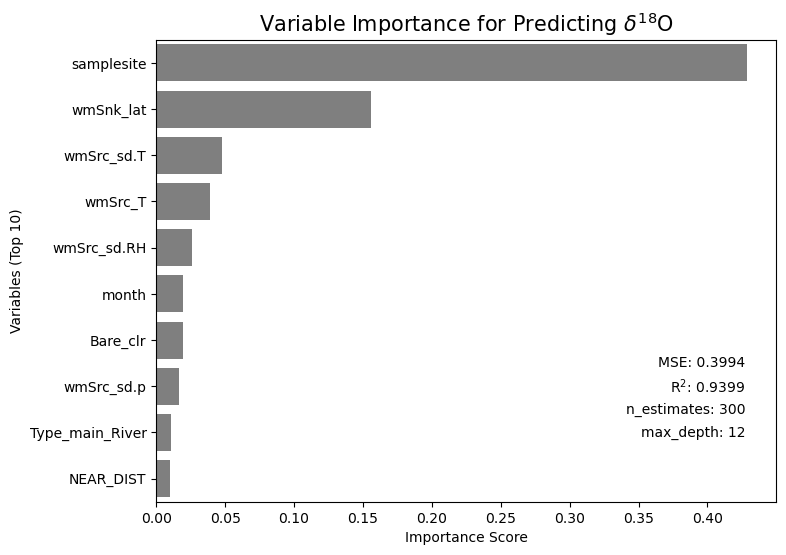

In [16]:
features = iso.columns.tolist()
to_drop = 0
features = np.delete(features, to_drop)

# feature importances in absteigender Reihenfolge sortieren
indices = np.argsort(modelfinal.feature_importances_)[::-1]
sorted_importances = modelfinal.feature_importances_[indices]
sorted_cols = [features[i] for i in indices]

# DataFrame mit Top10 features und ihren importances erstellen
df = pd.DataFrame({'Feature': sorted_cols[:10], 'Importance': sorted_importances[:10]})

# mit Seaborn plotten
plt.figure(figsize=(8, 6))
sns.barplot(x='Importance', y='Feature', data=df, color='black', alpha=0.5)

# Labels und Titel festlegen
plt.xlabel('Importance Score')
plt.ylabel('Variables (Top 10)')
plt.title('Variable Importance for Predicting $\delta^{18}$O', fontsize= 15)

#Auswertung angeben
plt.text(0.95, 0.3, f'MSE: {mse_final:.4f}', ha='right', va='center', transform=plt.gca().transAxes)
plt.text(0.95, 0.25, f'R$^2$: {r2_final:.4f}', ha='right', va='center', transform=plt.gca().transAxes)
plt.text(0.95, 0.20, f'n_estimates: {300}', ha='right', va='center', transform=plt.gca().transAxes)
plt.text(0.95, 0.15, f'max_depth: {12}', ha='right', va='center', transform=plt.gca().transAxes)

# Show plot
plt.show()

In [17]:
data = [['initial model', mse_model1, r2_model1],
        ['model with optimized n_estimates', best_mse_model2, 'nicht gemessen'],
        ['final model', mse_final, r2_final]]

# Erstelle einen DataFrame
df = pd.DataFrame(data, columns=['model', 'MSE', 'R$^2$'])
df

,model,MSE,R$^2$
0,initial model,0.447087,0.932734
1,model with optimized n_estimates,0.408283,nicht gemessen
2,final model,0.399401,0.939909


Im Vergleich zum ersten Durchlauf ist der MSE gesunken und der R²-Koeffizient leicht gestiegen. Das Anpassen der Parameter hat also zu einer Verbesserung des Modells geführt.